In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load the dataset

In [3]:
def load_dataset(
    start_date: str = '1999-12-31',
    end_date: str = '2019-01-01') -> np.ndarray:
    '''
    Parameters
    ----------
    start_date: str, start date of the stock dataset, default = '1999-12-31'
    end_date: str, end date of the stock dataset, default = '2019-01-01'
    
    Returns
    -------
    np.ndarray
    '''
    data_raw = pd.read_csv('data_ml.csv', index_col=0)
    data_raw.reset_index(inplace=True)
    del data_raw['index']

    idx_date = data_raw.index[(data_raw['date'] > start_date) & (data_raw['date'] < end_date)].to_list()
    data_ml = data_raw.iloc[idx_date]
    
    return data_ml

In [4]:
data_ml = load_dataset()

## Swarmplot of correlations with the 1-month forward return

In [6]:
features_short = ['Div_Yld', 
                 'Eps',
                 'Mkt_Cap_12M_Usd',
                 'Mom_11M_Usd',
                 'Ocf',
                 'Pb',
                 'Vol1Y_Usd']
cols = features_short + ['R1M_Usd', 'date']

In [7]:
data_corr = data_ml[cols]
data_corr = data_corr.groupby('date').corr()[['R1M_Usd']].reset_index()
data_corr = data_corr.loc[data_corr[data_corr['level_1'].str[-7:] != 'R1M_Usd'].index]
data_corr.rename(columns={'level_1': 'Factors'}, inplace = True)

/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 7.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 7.9% of the points

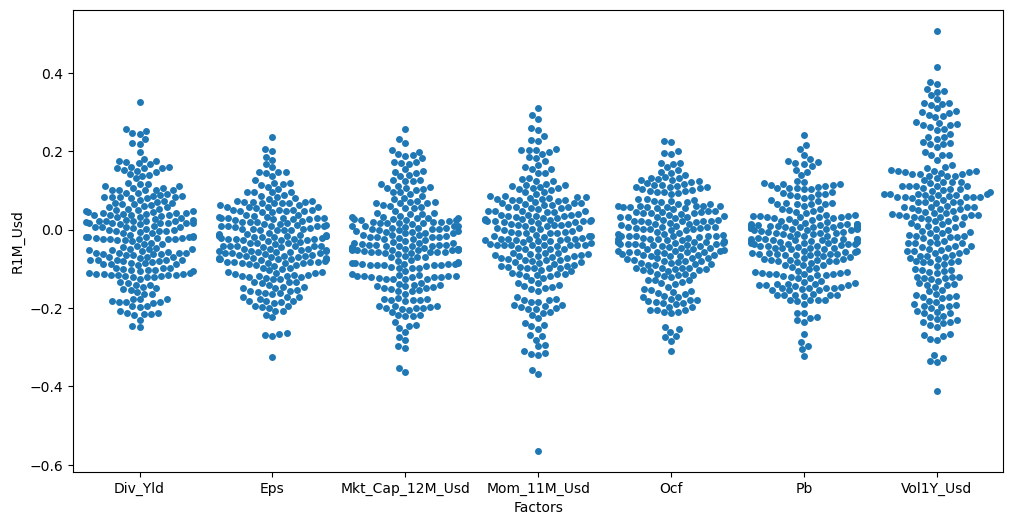

In [8]:
plt.figure(figsize=(12, 6))
sns.swarmplot(x='Factors', y='R1M_Usd', data=data_corr)
plt.show()

## Conditional average

In [10]:
unpivoted_data_ml = pd.melt(data_ml[['R1M_Usd', 'Mkt_Cap_12M_Usd', 'Vol1Y_Usd']],
                            id_vars = 'R1M_Usd')

In [11]:
unpivoted_data_ml.head()

,R1M_Usd,variable,value
0,0.089,Mkt_Cap_12M_Usd,0.24
1,0.039,Mkt_Cap_12M_Usd,0.24
2,-0.012,Mkt_Cap_12M_Usd,0.25
3,0.174,Mkt_Cap_12M_Usd,0.33
4,-0.106,Mkt_Cap_12M_Usd,0.30


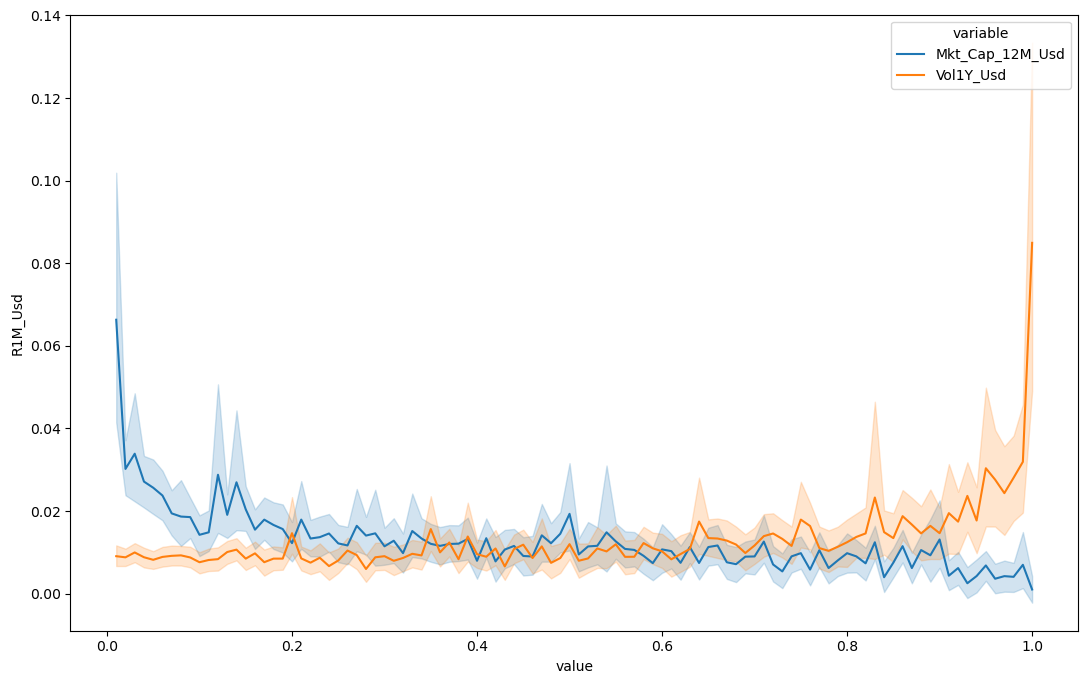

In [12]:
plt.figure(figsize=(13, 8))
sns.lineplot(data = unpivoted_data_ml,
             y = 'R1M_Usd',
             x = 'value',
             hue = 'variable')
plt.show()

## Autocorrelation

In [14]:
cols = ['stock_id'] + list(data_ml.iloc[:,3:95].columns)

In [15]:
data_hist_acf = pd.melt(data_ml[cols],
                        id_vars = 'stock_id').groupby(['stock_id', 'variable']).apply(lambda x: x['value'].autocorr(lag=1))

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/jz/_62zm7jn3y754w_n7gcp4v3m0000gn/T/ipykernel_13580/404374728.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  id_vars = 'stock_id').groupby(['stock_id', 'variable']).apply(lambda x: x['value'].autocorr(lag=1))


In [16]:
data_hist_acf.head()

stock_id  variable      
1         Advt_3M_Usd       0.958424
          Advt_6M_Usd       0.969035
          Asset_Turnover    0.825649
          Bb_Yld            0.606740
          Bv                0.998723
dtype: float64

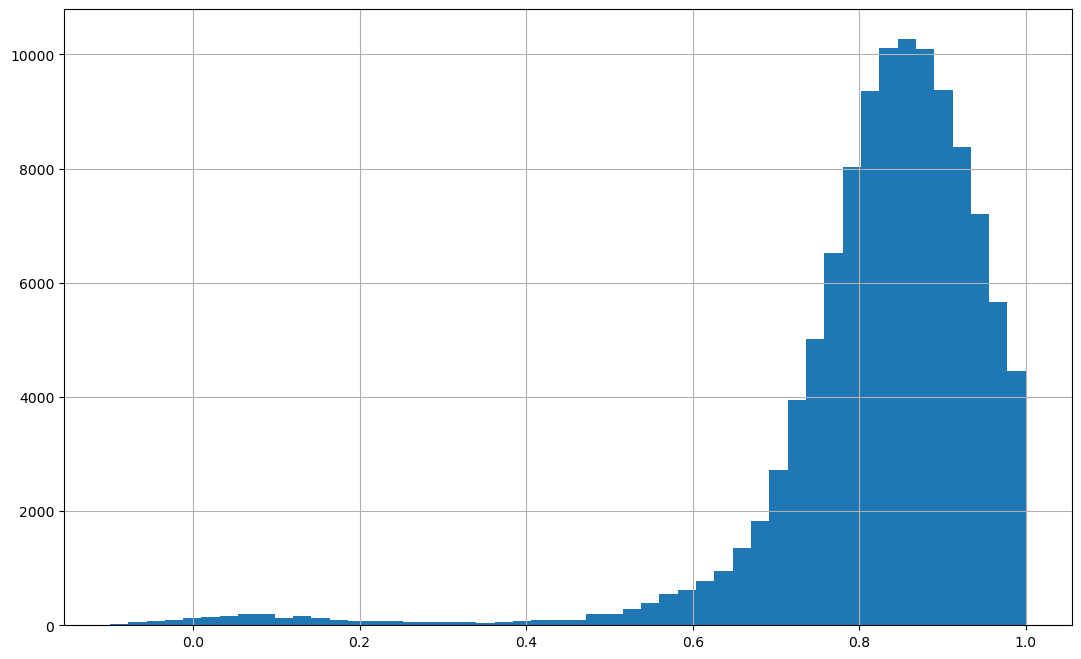

In [17]:
plt.figure(figsize=(13, 8))
data_hist_acf.hist(bins=50, range=[-0.1, 1])
plt.show()